In [4]:
import sys
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from recommenders.evaluation.python_evaluation import (
    ndcg_at_k, precision_at_k, recall_at_k
)
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVD, model_selection, accuracy
from collections import defaultdict




In [5]:
ratings = pd.read_csv('books_data/ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books = pd.read_csv('books_data/books.csv', sep=';', error_bad_lines=False, encoding="latin-1")

C:\Users\hamza\AppData\Local\Temp\ipykernel_57152\2762359282.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  ratings = pd.read_csv('books_data/ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
C:\Users\hamza\AppData\Local\Temp\ipykernel_57152\2762359282.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('books_data/books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9

Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 

In [6]:
ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


C:\Users\hamza\AppData\Local\Temp\ipykernel_57152\3033648102.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Book-Rating", data=ratings, palette="viridis")


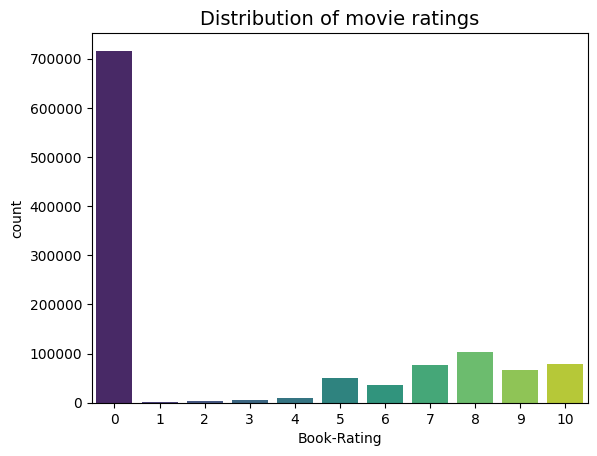

In [7]:
sns.countplot(x="Book-Rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

C:\Users\hamza\AppData\Local\Temp\ipykernel_57152\3560009944.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Book-Rating", data=ratings_explicit, palette="viridis")


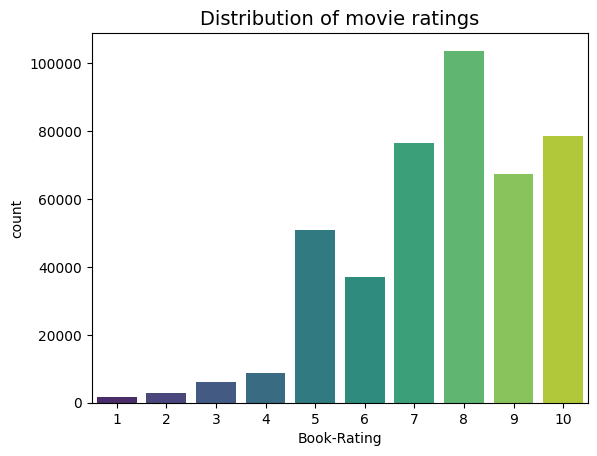

In [8]:
ratings_explicit = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=ratings_explicit, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [9]:
books_df= pd.merge(books, ratings_explicit, on='ISBN')
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,67544,8
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,116866,9
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,123629,9


In [10]:
books_df.rename(columns = {'Book-Title':'title', 'Book-Author' : 'author', 'User-ID' : 'userID', 'Book-Rating' : 'rating','ISBN' : 'itemID'  }, inplace = True) 
books_df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Year-Of-Publication', 'Publisher'], axis= 1, inplace=True)
books_df = books_df[['userID', 'itemID', 'rating', 'title', 'author']]
books_df.head()


,userID,itemID,rating,title,author
0,8,0002005018,5,Clara Callan,Richard Bruce Wright
1,11676,0002005018,8,Clara Callan,Richard Bruce Wright
2,67544,0002005018,8,Clara Callan,Richard Bruce Wright
3,116866,0002005018,9,Clara Callan,Richard Bruce Wright
4,123629,0002005018,9,Clara Callan,Richard Bruce Wright


In [11]:
unique_userIds = books_df['userID'].unique()
unique_userIds.sort()

# Create a mapping from old userIds to new ones (starting from 1)
user_id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_userIds, start=1)}

# Apply the mapping to the userIds column
books_df['userID'] = books_df['userID'].map(user_id_mapping)
books_df.sort_values(by='userID', ascending=True)

,userID,itemID,rating,title,author
0,1,0002005018,5,Clara Callan,Richard Bruce Wright
45,1,1881320189,7,Goodbye to the Buttermilk Sky,Julia Oliver
44,1,1575663937,6,More Cunning Than Man: A Social History of Rat...,Robert Hendrickson
43,1,1567407781,6,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman
39,1,1552041778,5,Jane Doe,R. J. Kaiser
...,...,...,...,...,...
297720,68091,0425163393,7,Kat Scratch Fever (Kat Colorado Mysteries),Karen Kijewski
106514,68091,0375703063,7,A Virtuous Woman (Oprah's Book Club (Paperback)),Kaye Gibbons
56223,68091,0553579606,8,Ashes to Ashes,TAMI HOAG
74471,68091,042516098X,7,Hornet's Nest,Patricia Daniels Cornwell


In [12]:
unique_itemIds = books_df['itemID'].unique()

# Create a mapping from old itemIdsunique_itemIds to new ones (starting from 1)
item_id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_itemIds, start=1)}

# Apply the mapping to the itemIdsunique_itemIds column
books_df['itemID'] = books_df['itemID'].map(item_id_mapping)
books_df.sort_values(by='itemID', ascending=True)

,userID,itemID,rating,title,author
0,1,1,5,Clara Callan,Richard Bruce Wright
1,2720,1,8,Clara Callan,Richard Bruce Wright
2,16636,1,8,Clara Callan,Richard Bruce Wright
3,28664,1,9,Clara Callan,Richard Bruce Wright
4,30294,1,9,Clara Callan,Richard Bruce Wright
...,...,...,...,...,...
383837,67217,149832,10,Dreamsnake,Vonda N. McIntyre
383838,67366,149833,7,Cocktail Classics,David Biggs
383839,67459,149834,5,Flashpoints: Promise and Peril in a New World,Robin Wright
383840,67488,149835,7,There's a Bat in Bunk Five,Paula Danziger


In [13]:
n_books = books_df['itemID'].nunique()
n_users = books_df['userID'].nunique()
n_ratings = (books_df['rating']).sum() 


print(f"Number of ratings: {n_ratings}")
print(f"Number of unique books's: {n_books}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per book: {round(n_ratings/n_books, 2)}")





Number of ratings: 2927448
Number of unique books's: 149836
Number of unique users: 68091
Average number of ratings per user: 42.99
Average number of ratings per book: 19.54


In [14]:
books_df['title'].value_counts()[0:10]

The Lovely Bones: A Novel                           707
Wild Animus                                         581
The Da Vinci Code                                   494
The Secret Life of Bees                             406
The Nanny Diaries: A Novel                          393
The Red Tent (Bestselling Backlist)                 383
Bridget Jones's Diary                               377
A Painted House                                     366
Life of Pi                                          336
Harry Potter and the Chamber of Secrets (Book 2)    326
Name: title, dtype: int64

In [15]:
print(f"Mean global rating: {round(books_df['rating'].mean(),2)}.")

mean_ratings = books_df.groupby('userID')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 7.63.
Mean rating per user: 7.49.


In [16]:
books_df[books_df['author']== "Marcus Aurelius"]


,userID,itemID,rating,title,author
112894,2221,9114,10,The Meditations of Marcus Aurelius Antoninus (...,Marcus Aurelius
192371,2720,26942,10,Meditations (Penguin Classics),Marcus Aurelius
192372,4233,26942,5,Meditations (Penguin Classics),Marcus Aurelius
192373,39841,26942,7,Meditations (Penguin Classics),Marcus Aurelius
192374,46048,26942,10,Meditations (Penguin Classics),Marcus Aurelius
192375,53434,26942,9,Meditations (Penguin Classics),Marcus Aurelius
249073,8908,50380,10,Meditations (Dover Thrift Editions),Marcus Aurelius
249074,28512,50380,9,Meditations (Dover Thrift Editions),Marcus Aurelius
249075,49439,50380,9,Meditations (Dover Thrift Editions),Marcus Aurelius
271493,64825,61924,8,"Meditations (Everyman's Library, No. 55)",Marcus Aurelius


In [17]:
count = books_df['title'].count()
unique = books_df['title'].nunique()

print(f"There are {count} books and {unique} unique books")

There are 383842 books and 135567 unique books


In [18]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(books_df[['userID', 'itemID', 'rating']], reader)

In [19]:
trainset, testset = train_test_split(data, test_size=0.25)

In [20]:
model = SVD()
model.fit(trainset)

In [21]:
predictions = model.test(testset)

In [22]:
accuracy.rmse(predictions)

RMSE: 1.6408


1.6407718781490779

In [23]:
print(predictions[2])

user: 39670      item: 651        r_ui = 8.00   est = 9.60   {'was_impossible': False}


In [24]:
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
    return top_n

In [25]:
top_n = get_top_n(predictions, n=10)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

7314 [10797, 10798, 540, 579, 427, 18713, 6259, 6936, 12719, 2215]
67437 [6906, 1554, 41346, 184, 20739, 6615, 45787, 488, 41350, 23514]
39670 [651, 1163, 1379, 45078, 8797, 35370, 17860, 4690, 8951, 24382]
64235 [15825]
37140 [1296, 99494, 138339, 140419, 123110, 63375, 140413, 24816, 2630, 128838]
37574 [10664, 1985, 28751, 19773, 70661, 54154]
64980 [3903, 28100, 1218, 18843, 42889, 956, 62650, 53820, 62458, 244]
26910 [1353, 4647, 7256, 99084, 99080, 59520, 114329, 63589, 589, 66757]
40785 [1119, 115886, 16724, 115922, 115908, 115903, 52597, 115924, 115890, 115900]
64202 [24657, 58908, 12840, 8710, 49597, 13556, 35053]
20803 [6906, 18128, 13572, 69289, 7695, 7354, 2307, 35964, 22288, 5099]
53594 [19435, 71182, 1627, 36411, 6788, 34340]
33269 [130908, 86903, 130921, 130899, 130919, 2053, 64889, 5387]
2720 [63, 1154, 1264, 4873, 2431, 1208, 1869, 12771, 5545, 16343]
42566 [9512, 19633, 1196, 16513, 10519, 7782, 1482, 14022, 23935, 28573]
60773 [3202, 6491, 37031, 5004, 2538, 20875, 3

In [26]:
top_n[66039]

[(16522, 8.592725636365365),
 (9078, 8.559991932275656),
 (66452, 8.165946474667857)]

In [27]:
users = []
items = []
preds = []

# Extract data from each prediction object
for pred in predictions:
    users.append(pred.uid)
    items.append(pred.iid)
    preds.append(pred.est)

# Create a DataFrame with the extracted data
all_predictions = pd.DataFrame(data={
    "userID": users,
    "itemID": items,
    "prediction": preds
})

all_predictions

,userID,itemID,prediction
0,7314,6259,7.785595
1,67437,976,6.316581
2,39670,651,9.596199
3,64235,15825,7.665983
4,37140,140419,6.913660
...,...,...,...
95956,59449,1577,7.840452
95957,2720,49582,7.407444
95958,60364,423,7.059719
95959,14054,14422,7.215098


In [28]:
testset[0:10]

[(7314, 6259, 7.0),
 (67437, 976, 8.0),
 (39670, 651, 8.0),
 (64235, 15825, 10.0),
 (37140, 140419, 9.0),
 (37574, 54154, 7.0),
 (64980, 53820, 8.0),
 (26910, 99084, 4.0),
 (40785, 115922, 9.0),
 (64202, 58908, 10.0)]

In [29]:
users_test = []
items_test = []
ratings_test = []

# Extract data from each prediction object
for row in testset:
    users_test.append(row[0])
    items_test.append(row[1])
    ratings_test.append(row[2])

# Create a DataFrame with the extracted data
test_eval_set = pd.DataFrame(data={
    "userID": users_test,
    "itemID": items_test,
    "rating": ratings_test
})

test_eval_set.sort_values(by='userID', ascending=True)

,userID,itemID,rating
59500,1,9,5.0
69205,4,22,6.0
58824,4,20,5.0
65599,5,24,9.0
8568,6,41954,5.0
...,...,...,...
47265,68085,2036,8.0
11653,68085,361,9.0
6399,68087,3569,8.0
81319,68089,16960,5.0


In [30]:

eval_ndcg = ndcg_at_k(test_eval_set, all_predictions, col_prediction='prediction', k=10)
eval_precision = precision_at_k(test_eval_set, all_predictions, col_prediction='prediction', k=10)
eval_recall = recall_at_k(test_eval_set, all_predictions, col_prediction='prediction', k=10)

print(accuracy.rmse(predictions),
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

RMSE: 1.6408
1.6407718781490779
NDCG:	1.000000
Precision@K:	0.228737
Recall@K:	0.977416


In [31]:
def calculate_f1_score(precision_at_k, recall_at_k):
    """
    Calculate the F1 score from Precision@K and Recall@K.

    Args:
        precision_at_k (float): Precision at K.
        recall_at_k (float): Recall at K.

    Returns:
        float: The F1 score calculated from Precision@K and Recall@K.
    """
    # Check for cases where both precision and recall are zero.
    if precision_at_k + recall_at_k == 0:
        return 0.0
    
    f1_score = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
    return f1_score

In [32]:
f1_score = calculate_f1_score(eval_precision, eval_recall)
print(f"F1 Score: {f1_score}")

F1 Score: 0.3707179128168767
